In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

# mission 지연변수 만들기
* 각 농가별 주차별로
* 농가 모두 합쳐서 전체 표본을 대상으로
</br>
</br>지연 시간은 5주 ~ 10주까지 돌려보자
1. 생장길이
2. 경경
3. 화방높이

In [129]:
# 생육 데이터
# 넓은들_송태근,제일_황종운 제외
sang_list =[
    
    #'대수농장_이중범_생육',
    '로즈밸리_정병두_생육',
    '마이산토마토_강성백_생육',
    '민수네토마토_강윤성_생육',
    #'바구리봉_임윤호_생육',
    #'번영농장_권현자_감마_생육',
    #'번영농장_권현자_레드250_생육',
    #'봉대농장_조봉대_생육',
    '오마이토마토_오길택_생육',
    #'으뜸_김재원_생육',
    '장수파프리카_김인기_생육',
    '장수파프리카_김인기_생육2',
    '지수농장_김경환_생육',
    #'지평선농원_안경엽_생육',
    '지평선농장_안상천_생육',
    '천천팜_송완섭_생육',
    '천천팜_송완섭_생육2',
    #'태봉_하수용_생육',
    '털보_박병준-생육',
    '하늘아래_김선배_생육',
    '해오름_한동근_생육',
    '해오름_한동근_생육2',
    '햇살농장_김영호_생육',
    '현가농장_김대만_생육',
    #'희망농원_허덕문_생육',
]

# 환경 데이터
env_list =[
    #'대수농장_이중범_환경',
    '로즈밸리_정병두_환경',
    '마이산토마토_강성백_환경',
    '민수네토마토_강윤성_환경',
    #'바구리봉_임윤호_환경',
    #'번영농장_권현자_환경',
    #'번영농장_권현자_환경',
    #'봉대농장_조봉대_환경',
    '오마이토마토_오길택_환경',
    #'으뜸_김재원_환경',
    '장수파프리카_김인기_환경',
    '장수파프리카_김인기_환경2',
    '지수농원_김경환_환경',
    #'지평선농원_안경엽_환경',
    '지평선농장_안상천_환경',
    '천천팜_송완섭_환경',
    '천천팜_송완섭_환경2',
    #'태봉_하수용_환경',
    '털보농장_박병준_환경',
    '하늘아래_김선배_환경',
    '해오름_한동근_환경',
    '해오름_한동근_환경2',
    '햇살농장_김영호_환경',
    '현가농장_김대만_환경',
    #'희망농원_허덕문_환경'
]

----
# 사용자 지정함수

In [142]:
# 생육 데이터 로드
def sang_data_load(sang_farm_name,col):
    n = 'C:\\농업기술원\\1차\\2018\\2018-2019 토마토_생육(원본)/'+sang_farm_name+'.xlsx'
    sang = pd.read_excel(n)
    sang = sang[col]
    return sang

In [143]:
# 환경 데이터 로드
def env_data_load(env_farm_name,col):
    n = 'C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)/'+env_farm_name+'.xlsx'
    #col = ['date', '내부온도', '내부습도', '지온', '지습', '이슬점', 'CO2', '외부온도', '풍속', '일사량', '누적일사량','강우', '포화수분', '절대습도', '수분부족분', '이중창환기온도', '환기온도', '난방온도']
    env = pd.read_excel(n)
    env = env[col]
    return env

In [144]:
# 주차 추가
def add_weeknum(sang_df):
    sang_df['diff']=sang_df['WeekNum'].shift(1)
    sang_df['diff2']=sang_df['WeekNum']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=0:
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [145]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [146]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [147]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['test_weeknum']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [148]:
# 1주일 단위로 각 변수 집계
def my_pivot(env_data,base_col,avg_col_list,sum_col_list):
    avg_col=base_col+avg_col_list
    sum_col=base_col+sum_col_list

    # 평균 DF
    avg_df=env_data[avg_col]
    avg_pivot=env_data.pivot_table(index='주차',
                                  values=avg_col_list,
                                  aggfunc='mean').reset_index()
    # 합 DF
    sum_df=env_data[sum_col]
    sum_pivot=env_data.pivot_table(index='주차',
                                  values=sum_col_list,
                                  aggfunc='sum').reset_index()
    
    
    return avg_pivot,sum_pivot

In [163]:
def box_to_find_outlier(env_data,name,cols):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name[:-3:])
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='주차',y=env)
        plt.title(name[:-3:]+'_'+env)
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
        

----
# 1. 환경 요인 데이터셋 구성하기

- 누적일사량을 증가량으로 바꿔주기

- 이상치 파악하기

로즈밸리_정병두


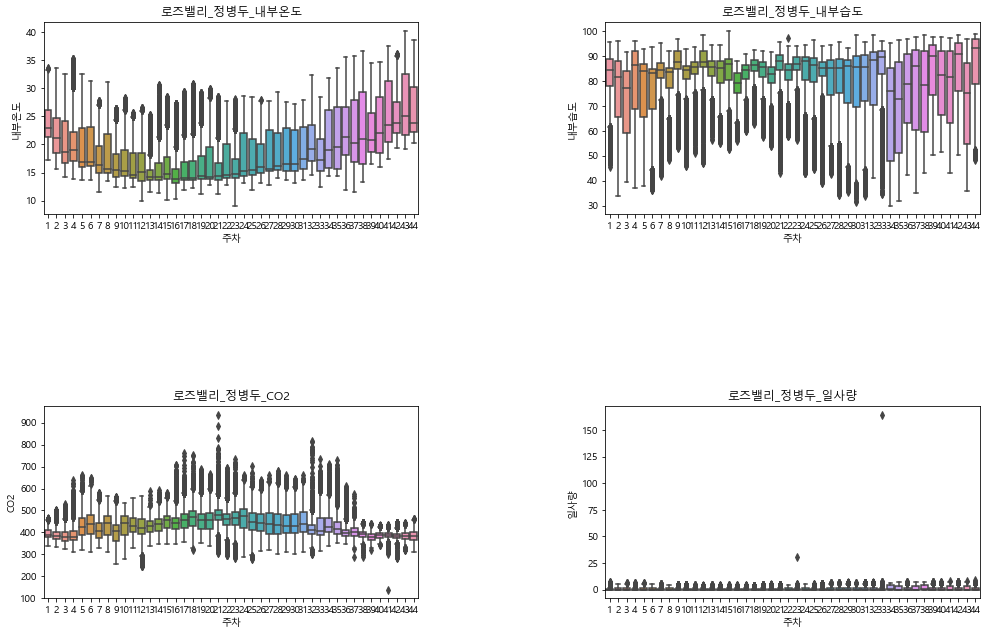

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
마이산토마토_강성백


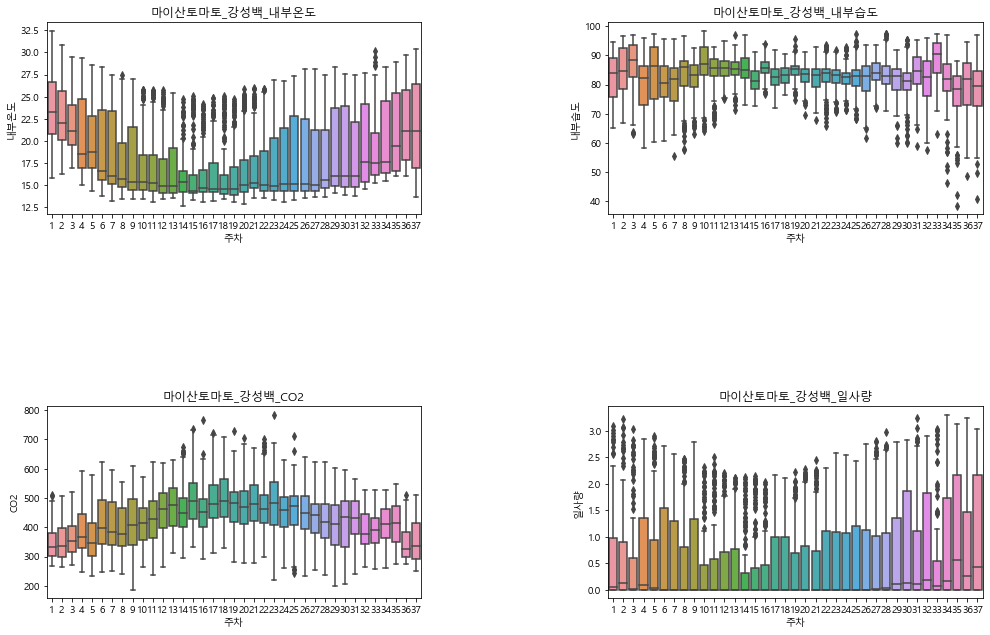

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
민수네토마토_강윤성


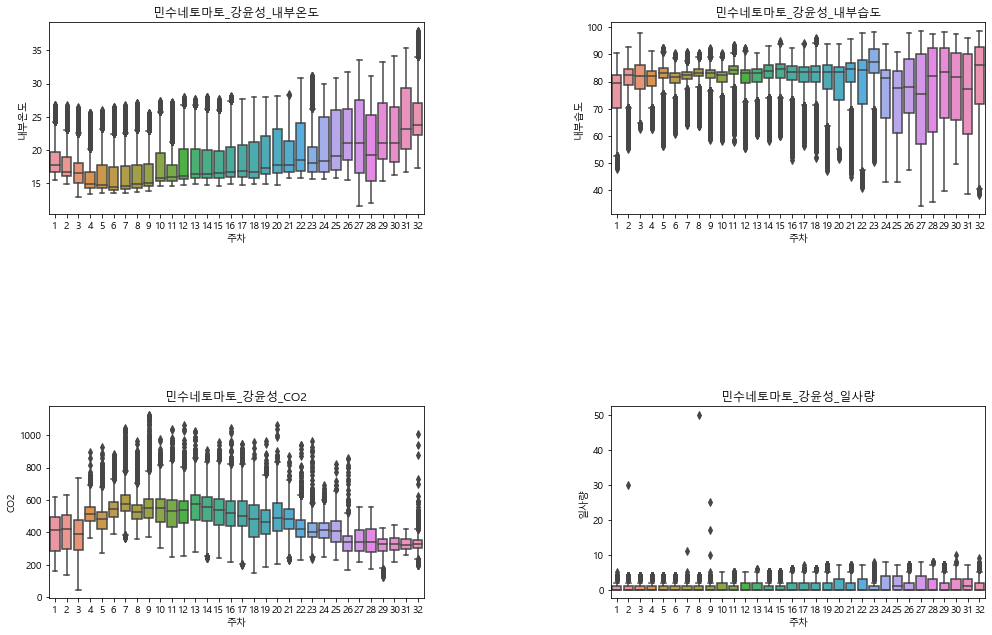

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
오마이토마토_오길택


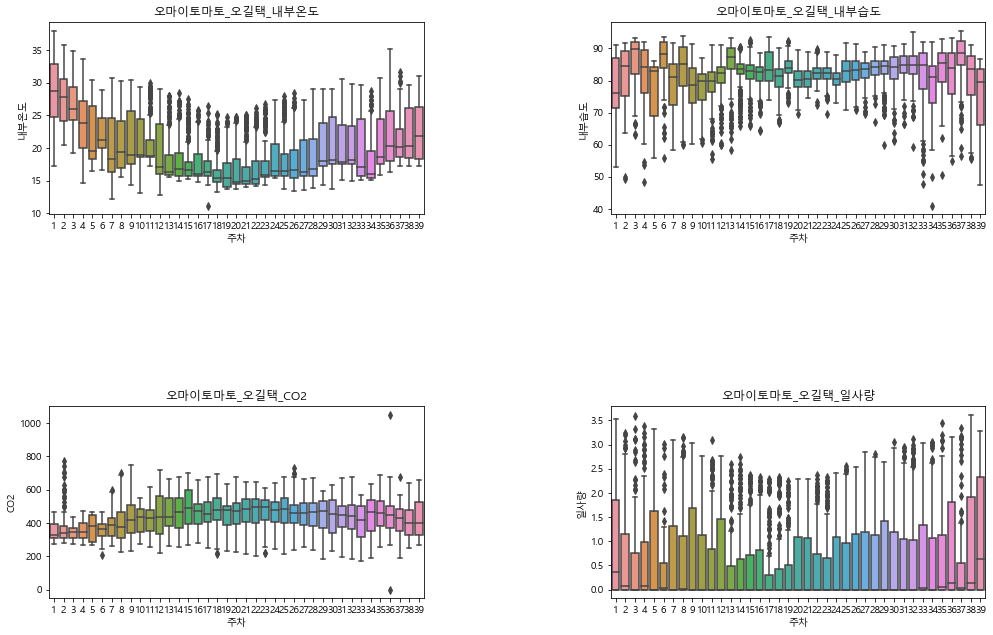

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
장수파프리카_김인기


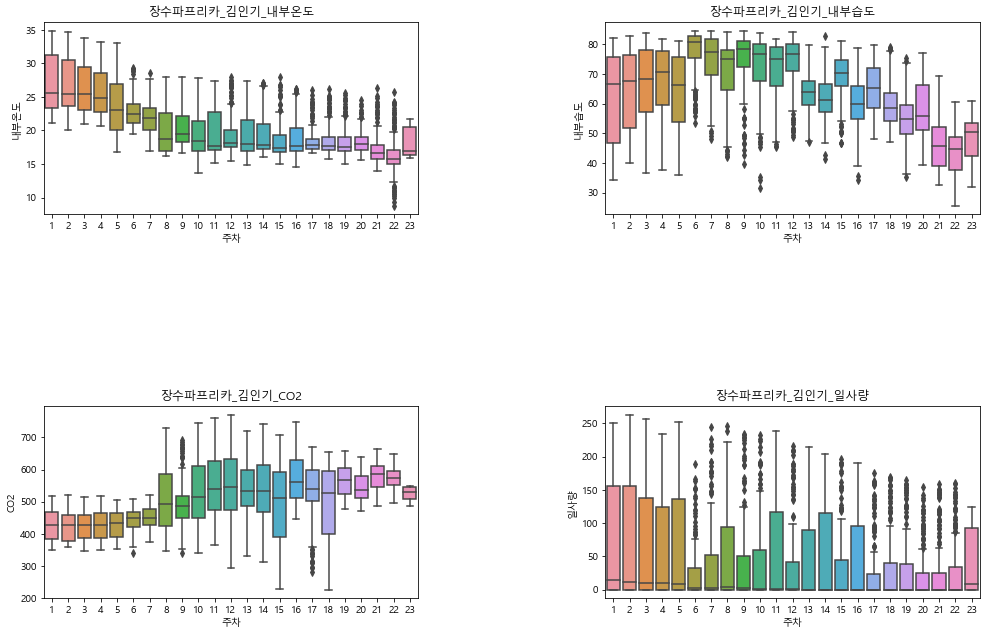

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
장수파프리카_김인기_


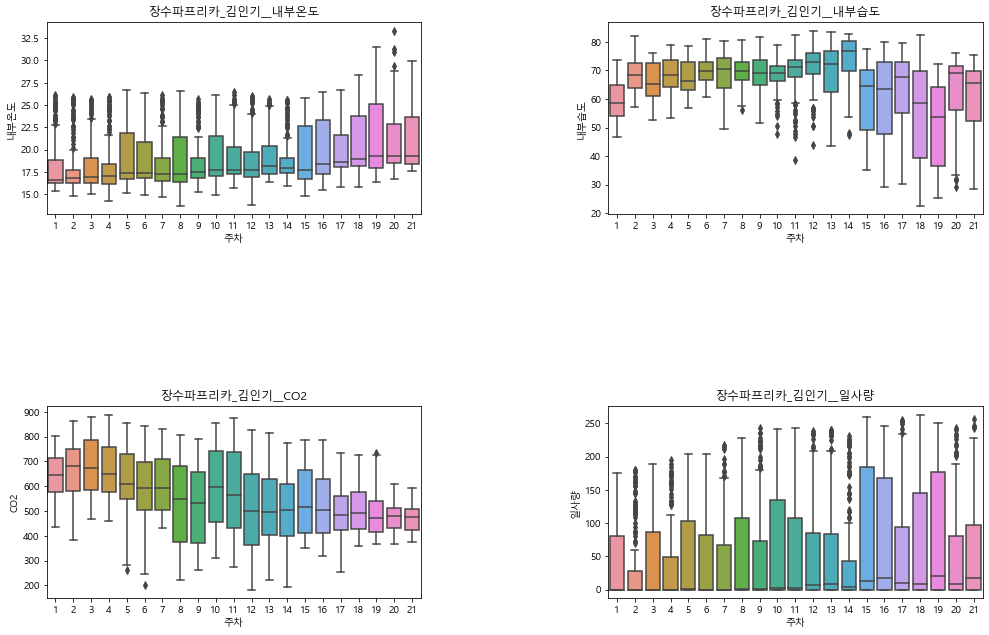

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
지수농장_김경환


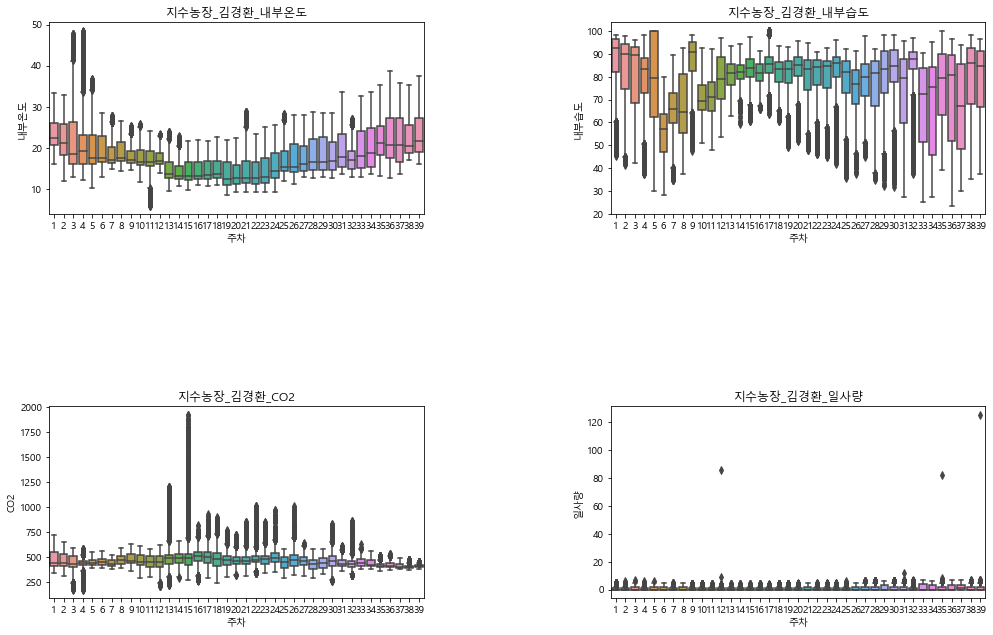

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
지평선농장_안상천


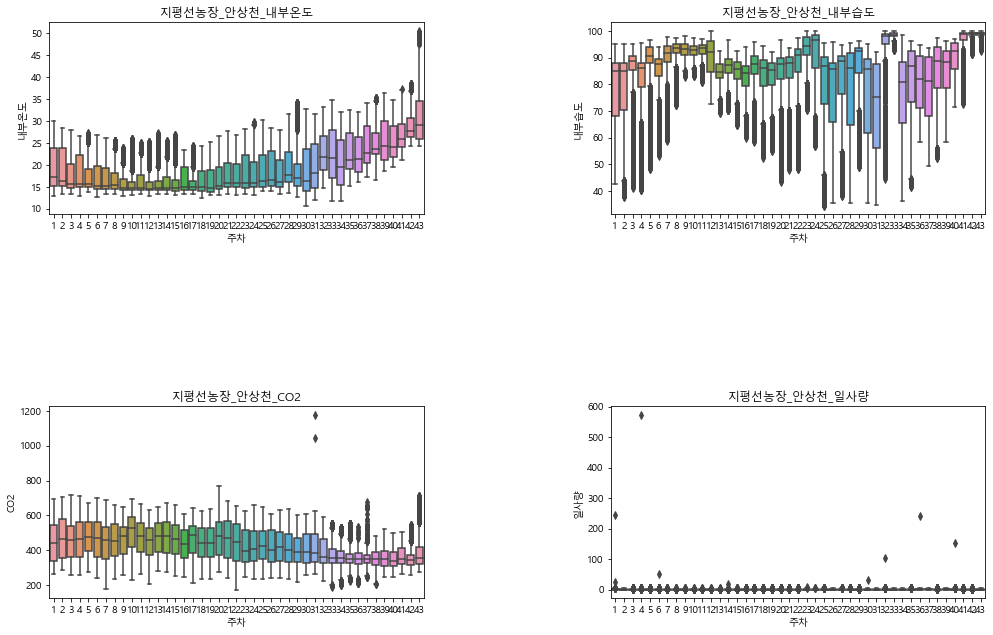

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
천천팜_송완섭


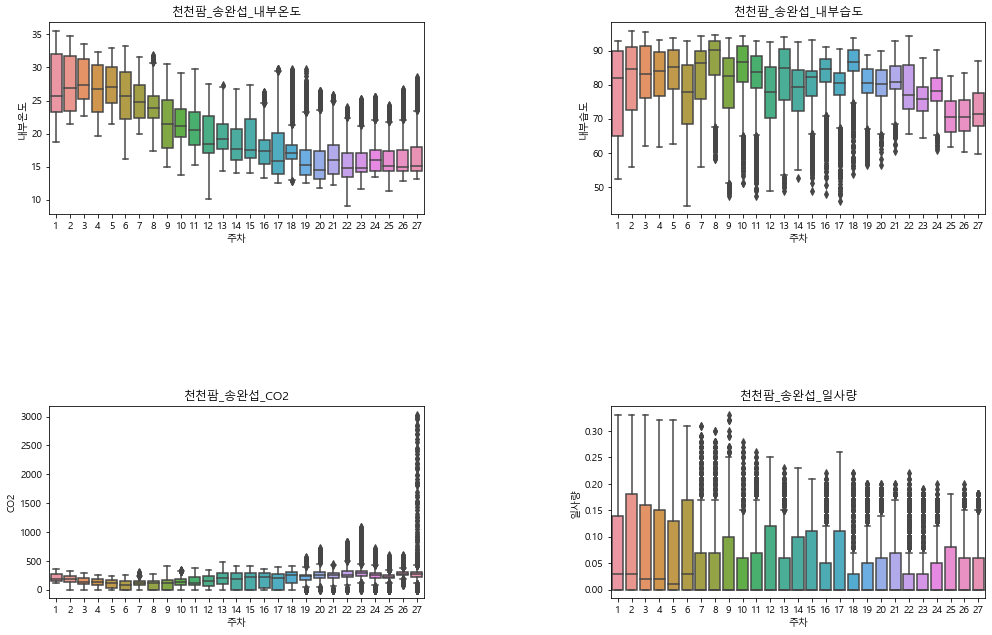

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
털보_박병준


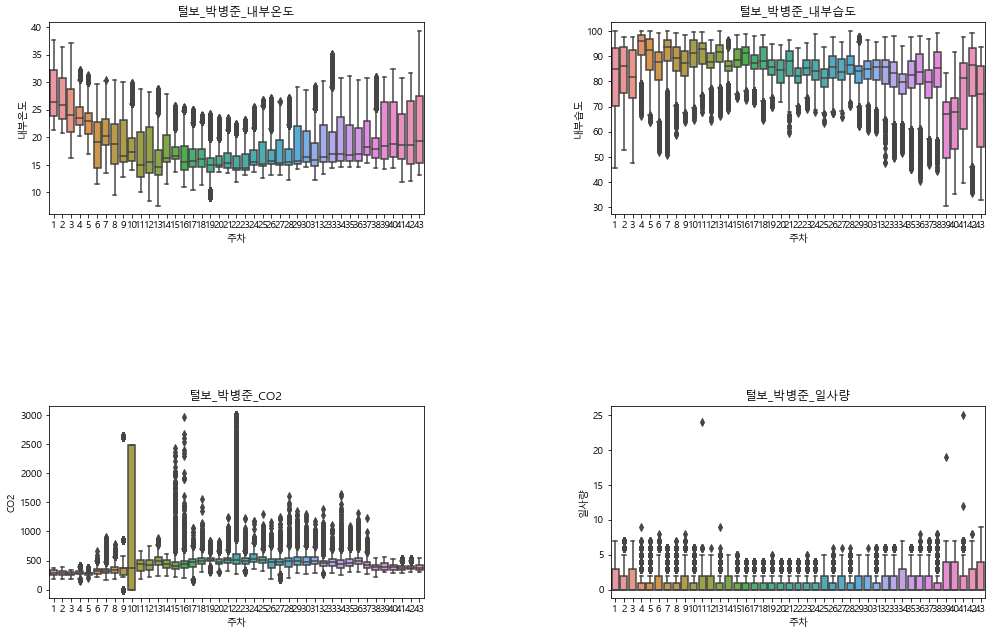

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
하늘아래_김선배


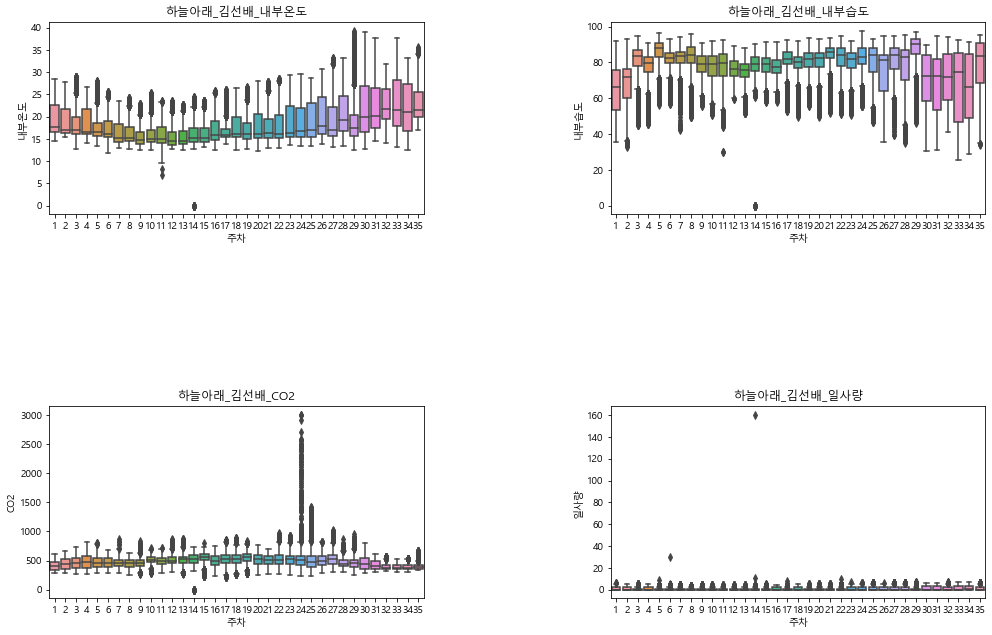

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
해오름_한동근


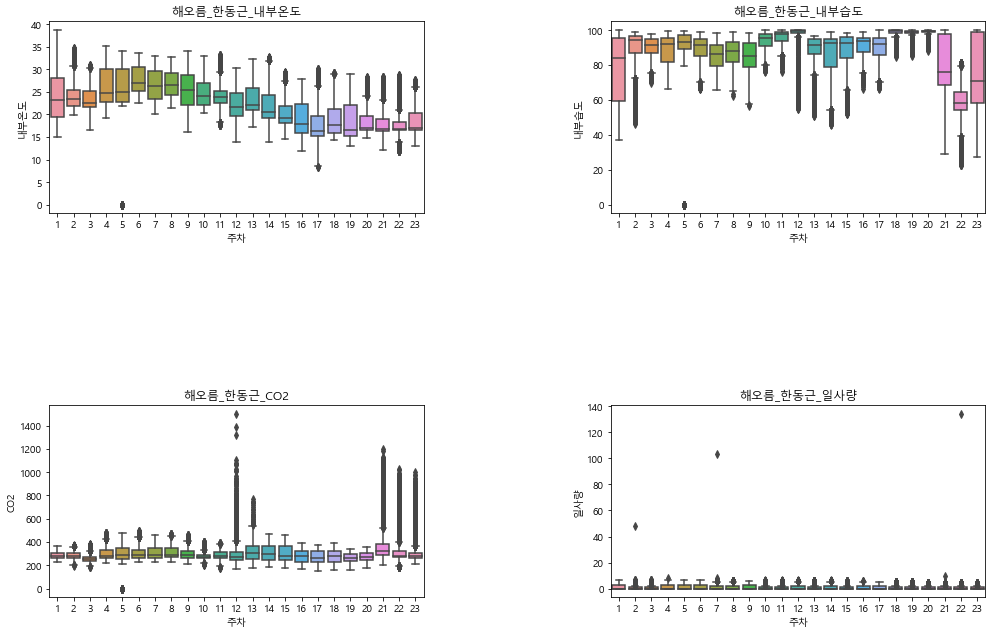

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
해오름_한동근_


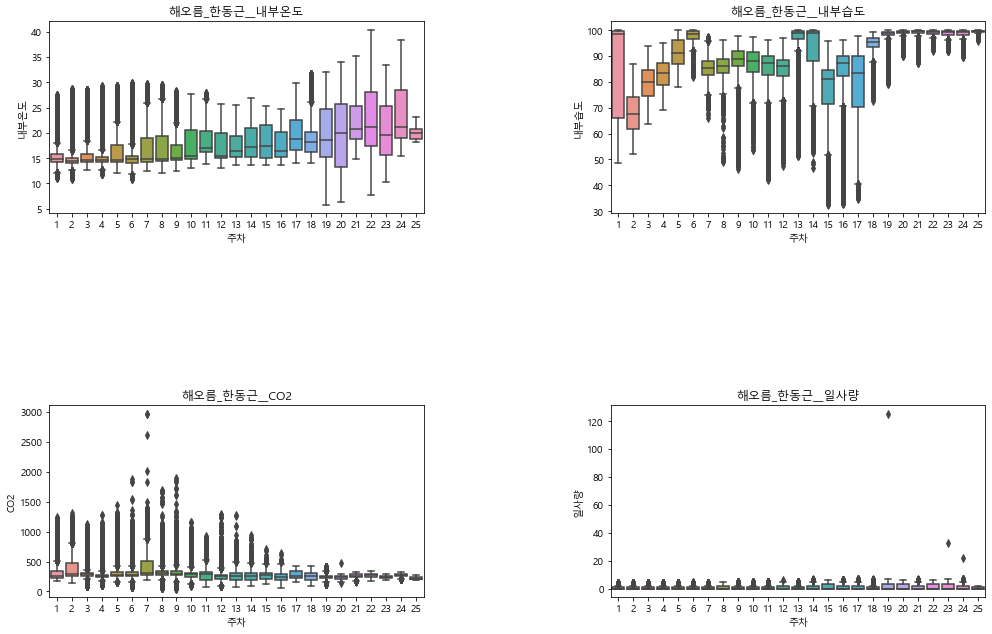

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
햇살농장_김영호


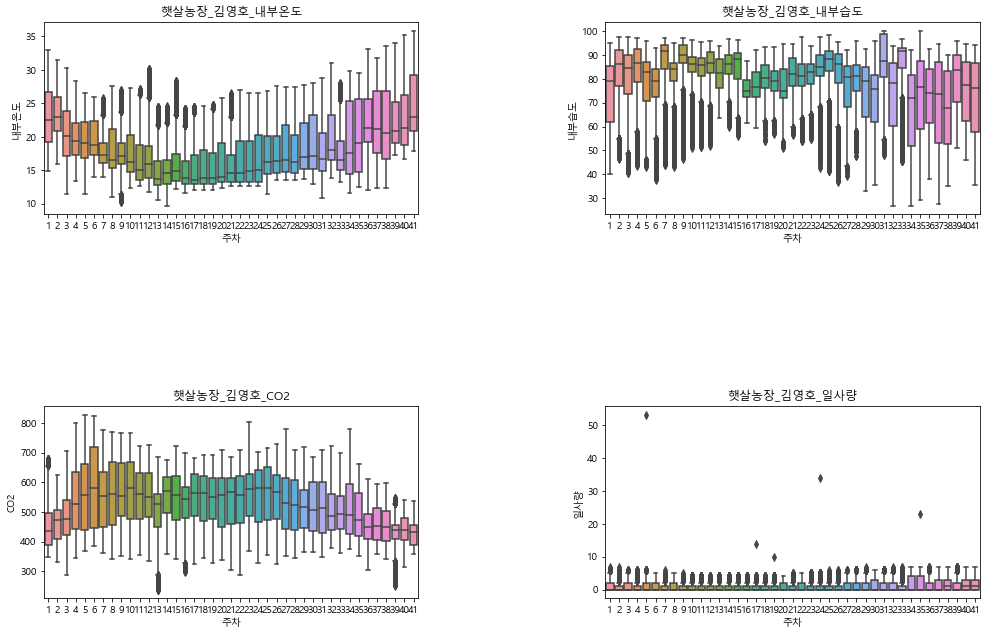

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------
현가농장_김대만


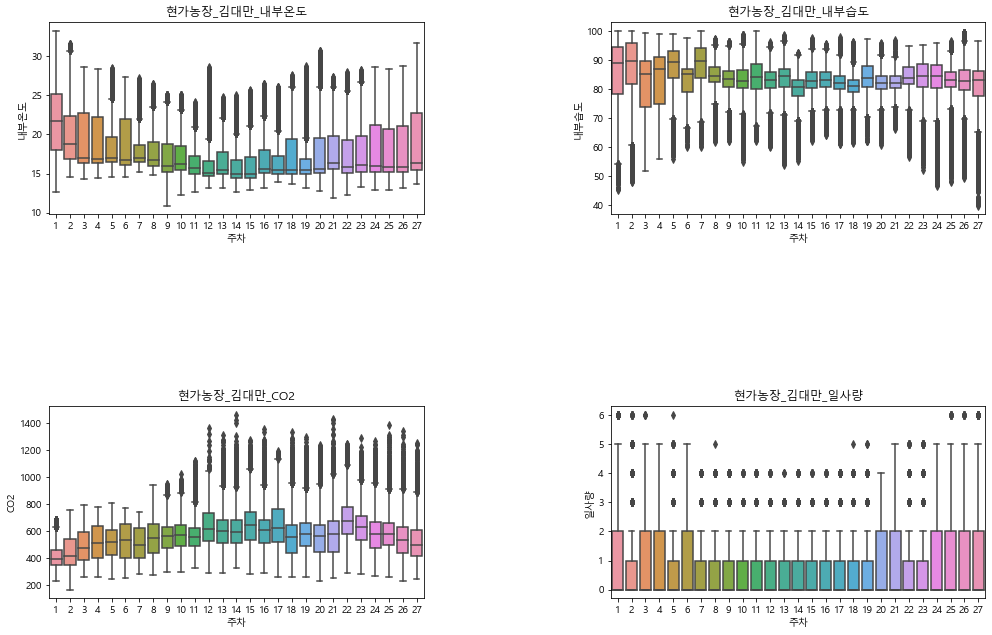

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [164]:
total_dataset=[]
for i in range(len(sang_list)):

    # 한 농장 sang 로드
    sang_col=['농가명', 'Date', 'Year', 'Month', 'Day', 'Week', 'WeekNum', 'Sample', '생장길이', '화방높이', '줄기굵기']
    sang_data = sang_data_load(sang_list[i],sang_col)
    
    
    # 한 농장 env 로드
    env_col = ['date', '내부온도', '내부습도', 'CO2', '누적일사량']
    env_data = env_data_load(env_list[i],env_col)

    # 한 농장에 주차 추가
    sang_data['test_weeknum']=add_weeknum(sang_data)

    # 환경에 Date컬럼 추가, 12시기준 쪼개기
    생육조사기간=sorted(list(set(list(sang_data['Date']))))
    env_data=env_add_Date(env_data,생육조사기간)

    # 환경 데이터에 주차 컬럼 추가
    env_data['주차']=match_test_weeknum(sang_data,env_data)

    # 누적을 증가량으로 바꿔주기
    base_col=['date','Date','주차']
    cumsum_list=['누적일사량']
    cumsum_col=base_col+cumsum_list

    cumsum_df=cumsum_to_value(env_data[cumsum_col])
    env_data['일사량']=cumsum_df['일사량']
    del env_data['누적일사량']


    # 환경 데이터 변수명
    avg_list=['내부온도','내부습도','CO2']
    sum_list=['일사량']
    
    cols=avg_list+sum_list
    
    # 이상치 파악하기
    name=sang_list[i]
    box_to_find_outlier(env_data,name,cols)
    
    total_dataset.append(env_data)

In [ ]:
# 피클로 저장
my_list = total_dataset
 
## Save pickle
with open("C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)\data.pickle","wb") as fw:
    pickle.dump(my_list, fw)
 
## Load pickle
#with open("C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)\data.pickle","rb") as fr:
 #   data = pickle.load(fr)

- 이상치를 어떻게 할 것인가.
1.일사량에 대한 이상치는 살펴본결과 중간에 측정이 끊겨서 그 사이동안 누적된 수치가 계산이 되어 발생하였다. </br>
해결책은?


2.co2는 정직하게 큰 숫자들이 찍힌것이긴하나..</br>
해결책은?



In [ ]:
total_dataset

- 주차별로 집계하기

In [198]:
# pivot
for df in total_dataset:
    avg_pivot,sum_pivot=my_pivot(env_data,base_col,avg_list,sum_list)

    result=pd.merge(avg_pivot,sum_pivot,how='inner')
    result

- 지연변수 생성하기

In [199]:
lag_result=result
for i in range(5):
    raw_col=result.columns[1:]
    later_df=result.iloc[:,1:].shift(periods=i+1)
    later_col=[str(i+1)+'주전_'+j for j in list(raw_col)]
    later_df.columns=later_col
    
    lag_result=pd.concat([lag_result,later_df],axis=1)

In [201]:
lag_result

,주차,CO2,내부습도,내부온도,일사량,1주전_CO2,1주전_내부습도,1주전_내부온도,1주전_일사량,2주전_CO2,2주전_내부습도,2주전_내부온도,2주전_일사량,3주전_CO2,3주전_내부습도,3주전_내부온도,3주전_일사량,4주전_CO2,4주전_내부습도,4주전_내부온도,4주전_일사량,5주전_CO2,5주전_내부습도,5주전_내부온도,5주전_일사량
0,1,413.393095,85.322314,21.778199,29353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,452.517262,86.330050,20.238571,9105.0,413.393095,85.322314,21.778199,29353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,491.095852,81.996120,19.368327,10566.0,452.517262,86.330050,20.238571,9105.0,413.393095,85.322314,21.778199,29353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,518.304861,83.393214,19.208194,9778.0,491.095852,81.996120,19.368327,10566.0,452.517262,86.330050,20.238571,9105.0,413.393095,85.322314,21.778199,29353.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,520.342063,86.536766,18.704653,7009.0,518.304861,83.393214,19.208194,9778.0,491.095852,81.996120,19.368327,10566.0,452.517262,86.330050,20.238571,9105.0,413.393095,85.322314,21.778199,29353.0,NaN,NaN,NaN,NaN
5,6,527.875099,82.746716,18.764702,9281.0,520.342063,86.536766,18.704653,7009.0,518.304861,83.393214,19.208194,9778.0,491.095852,81.996120,19.368327,10566.0,452.517262,86.330050,20.238571,9105.0,413.393095,85.322314,21.778199,29353.0
6,7,513.120536,88.032024,18.010298,4833.0,527.875099,82.746716,18.764702,9281.0,520.342063,86.536766,18.704653,7009.0,518.304861,83.393214,19.208194,9778.0,491.095852,81.996120,19.368327,10566.0,452.517262,86.330050,20.238571,9105.0
7,8,537.901181,84.055998,17.964858,6636.0,513.120536,88.032024,18.010298,4833.0,527.875099,82.746716,18.764702,9281.0,520.342063,86.536766,18.704653,7009.0,518.304861,83.393214,19.208194,9778.0,491.095852,81.996120,19.368327,10566.0
8,9,553.699306,82.835198,17.071567,6216.0,537.901181,84.055998,17.964858,6636.0,513.120536,88.032024,18.010298,4833.0,527.875099,82.746716,18.764702,9281.0,520.342063,86.536766,18.704653,7009.0,518.304861,83.393214,19.208194,9778.0
9,10,565.318948,82.860020,17.232530,5288.0,553.699306,82.835198,17.071567,6216.0,537.901181,84.055998,17.964858,6636.0,513.120536,88.032024,18.010298,4833.0,527.875099,82.746716,18.764702,9281.0,520.342063,86.536766,18.704653,7009.0


In [185]:
list(result.columns)

['주차', 'CO2', '내부습도', '내부온도', '일사량']

In [191]:
result.columns[1:]

Index(['CO2', '내부습도', '내부온도', '일사량'], dtype='object')